## Installs and Imports

In [184]:
%%capture
!pip install tqdm pyLDAvis gensim numpy bokeh
!conda install -c conda-forge huggingface_hub -y

In [185]:
%load_ext autoreload
%autoreload 2

In [186]:
import base64
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 0)
import warnings
warnings.filterwarnings("ignore")

## Data Acquisition via Gmail API

In [4]:
from quickstart import get_service, get_data
service = get_service()
messages = get_data(service, 'Medium Daily Digest')

In [5]:
print(len(messages))

596


### Regex Parsing of HTML Text

In [6]:
def parse_email_digest(date, msg_body):
    """ Returns a list of article information
        title, subtitle, author, publication, minutes (reading time)"""
    
    text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE).strip('\r')
    articles = [list(match) for match in re.findall('(.*)\r\n\r\n(.*)\r\n\r\n(.*) \r\n in (.*)\r\n*·(.*) min read', text, re.MULTILINE)]
    
    # workaround for old email Medium Daily Digest format prior to March 23, 2021
    if len(articles) == 0:
        articles = [list(match) for match in re.findall('(.*)\r\n\r\n(.*)\r\n(.*) \r\n\ in (.*)\r\n(.*) min read', text, re.MULTILINE)]
    return articles

data = []
num_articles_fetched = []
for message in tqdm(messages):
    
    # Get an email by id
    msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
    
    # Get date of email for the purpose of topic modeling over time
    for date_dict in msg['payload']['headers']:
        if date_dict['name'] == 'Date':
            date = date_dict['value']
    date = pd.to_datetime(date)

    # Get the email body and decode it from UTF-8
    content = msg['payload']['parts'][0]['body']['data']
    msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
    
    # Extract article information for all articles featured in daily digest
    fetched_articles = parse_email_digest(date, msg_body)
    num_articles_fetched.append(len(fetched_articles))
    for articles in fetched_articles:
        data.append([date, *articles])


100%|██████████| 596/596 [01:43<00:00,  5.75it/s]


In [82]:
# TROUBLESHOOT HERE
# identify all zero articles fetched digest emails
message = messages[num_articles_fetched.index(0)]
msg = service.users().messages().get(userId='me', id=message['id'], format='full').execute()
for date_dict in msg['payload']['headers']:
    if date_dict['name'] == 'Date':
        date = date_dict['value']
date = pd.to_datetime(date)
content = msg['payload']['parts'][0]['body']['data']
msg_body = base64.urlsafe_b64decode(content).decode('utf-8')
text = re.sub(r'\(https?:\S+.*\)', '', msg_body, flags=re.MULTILINE).strip('\r')
# print(text)

In [54]:
df = pd.DataFrame(data, columns = ['Date', 'Title', 'Subtitle', 'Author', 'Publication', 'Minutes'])
df['Minutes'] = df['Minutes'].astype(int)
df.to_csv('article_data_via_gmail_api.csv', index=False)
df

,Date,Title,Subtitle,Author,Publication,Minutes
0,2021-08-16 11:40:00+00:00,My Favorite Pandas Method Chains,Method chains I use (and reuse) because they'r...,Adam Ross Nelson,Level Up Coding,3
1,2021-08-16 11:40:00+00:00,Graph Thinking,A kind of cognitive framework called graph thi...,Paco Nathan,Knowledge Technologies,6
2,2021-08-16 11:40:00+00:00,Building and deploying end-to-end fake news cl...,In this digital era of smartphones and the int...,Eish Kumar,Towards Data Science,8
3,2021-08-16 11:40:00+00:00,Top 10 Machine Learning Algorithms You Should ...,Nowadays businesses are focusing on automation...,Nora Winkens,Artificial Intelligence in Plain English,4
4,2021-08-16 11:40:00+00:00,Scraping Tutorial on Airbnb's Website (with Sc...,Making your first steps in automating data col...,Thibaud Lamothe,Geek Culture,13
...,...,...,...,...,...,...
9211,2020-01-01 16:30:00+00:00,How to Get the Unquantifiable Benefits of Cold...,The surprising side effects that science can't...,May Pang,Better Humans,10
9212,2020-01-01 16:30:00+00:00,Screw Productivity Hacks: My Morning Routine I...,Anyone who brags about a 3:30 a.m. gym routine...,Jessica Valenti,GEN,3
9213,2020-01-01 16:30:00+00:00,The Latest Science on Chronic Pain Is Fascinat...,Experts can even predict who's likely to suffe...,Robert Roy Britt,Elemental,14
9214,2020-01-01 16:30:00+00:00,5 scientific myths you probably believe about ...,How a little knowledge can bring about some hu...,Ethan Siegel,Starts With A Bang!,8


In [187]:
df = pd.read_csv('article_data_via_gmail_api.csv')
df.head()

,Date,Title,Subtitle,Author,Publication,Minutes
0,2021-08-16 11:40:00+00:00,My Favorite Pandas Method Chains,Method chains I use (and reuse) because they'r...,Adam Ross Nelson,Level Up Coding,3
1,2021-08-16 11:40:00+00:00,Graph Thinking,A kind of cognitive framework called graph thi...,Paco Nathan,Knowledge Technologies,6
2,2021-08-16 11:40:00+00:00,Building and deploying end-to-end fake news cl...,In this digital era of smartphones and the int...,Eish Kumar,Towards Data Science,8
3,2021-08-16 11:40:00+00:00,Top 10 Machine Learning Algorithms You Should ...,Nowadays businesses are focusing on automation...,Nora Winkens,Artificial Intelligence in Plain English,4
4,2021-08-16 11:40:00+00:00,Scraping Tutorial on Airbnb's Website (with Sc...,Making your first steps in automating data col...,Thibaud Lamothe,Geek Culture,13


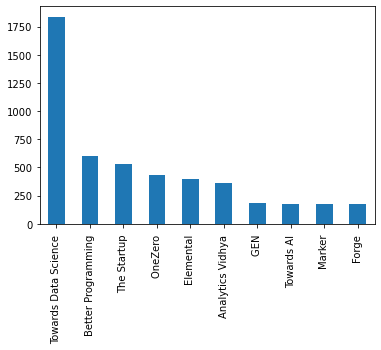

In [188]:
df['Publication'].value_counts().iloc[:10].plot.bar();

## Wordcloud

In [189]:
all_words = df['Title'].to_string().split()
all_words[:10]

['0',
 'My',
 'Favorite',
 'Pandas',
 'Method',
 'Chains',
 '1',
 'Graph',
 'Thinking',
 '2']

(-0.5, 2999.5, 1999.5, -0.5)

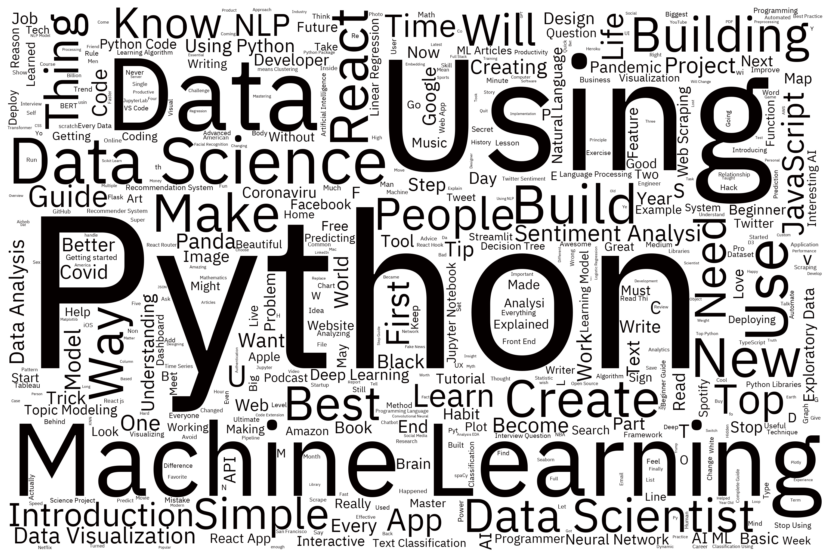

In [190]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

wordcloud = WordCloud(font_path = '~/Library/Fonts/IBMPlexSans-Regular.ttf', 
                      background_color="white", width=3000, height=2000, collocations=True,
                      max_words=500, stopwords=STOPWORDS).generate_from_text(df['Title'].to_string())

# set the word color to black
wordcloud.recolor(color_func = black_color_func)
plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

## Topic Modeling Prep

In [222]:
# Gensim and LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# NLP stuff
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
nltk.download('wordnet')
import spacy

# Plotting tools
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

# Miscellaneous
from sklearn.manifold import TSNE
from pprint import pprint
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sejaldua/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Preprocessing

In [192]:
df['Titles_combined'] = df[['Title', 'Subtitle']].agg(' '.join, axis=1)
df[['Title', 'Subtitle', 'Titles_combined']].head()

,Title,Subtitle,Titles_combined
0,My Favorite Pandas Method Chains,Method chains I use (and reuse) because they'r...,My Favorite Pandas Method Chains Method chains...
1,Graph Thinking,A kind of cognitive framework called graph thi...,Graph Thinking A kind of cognitive framework c...
2,Building and deploying end-to-end fake news cl...,In this digital era of smartphones and the int...,Building and deploying end-to-end fake news cl...
3,Top 10 Machine Learning Algorithms You Should ...,Nowadays businesses are focusing on automation...,Top 10 Machine Learning Algorithms You Should ...
4,Scraping Tutorial on Airbnb's Website (with Sc...,Making your first steps in automating data col...,Scraping Tutorial on Airbnb's Website (with Sc...


In [194]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df['Title'].tolist()))
print(data_words[:1])
print("Total titles:", len(data_words))

[['my', 'favorite', 'pandas', 'method', 'chains']]
Total titles: 9216


In [126]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [195]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [196]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['favorite', 'panda', 'method', 'chain']]


In [127]:
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# def lemmatize_stemming(text):
#     return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# def preprocess(text):
#     result = []
#     for token in gensim.utils.simple_preprocess(text):
#         if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
#             result.append(lemmatize_stemming(token))
#     return result


In [128]:
# # Remove Stop Words
# data_words_nostops = remove_stopwords(data_words)

# # Form Bigrams
# data_words_bigrams = make_bigrams(data_words_nostops)

# # Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = [preprocess(' '.join(words)) for words in data_words_bigrams]

# print(data_lemmatized[:1])

[['favorit', 'panda', 'method', 'chain']]


### Lemmatization

In [197]:
# Create dictionary and corpus needed for topic modeling

# dictionary is a mapping of word_id --> word, as the variable name implies
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# the preprocessed and lemmatized documents themselves
texts = data_lemmatized

# corpus is a mapping of word_id --> word frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [198]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('favorite', 1), ('method', 1), ('panda', 1)]]

## Latent Dirichlet Allocation (LDA)

In [200]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [201]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.114*"learn" + 0.098*"machine" + 0.052*"life" + 0.046*"code" + 0.043*"way" '
  '+ 0.036*"change" + 0.030*"model" + 0.027*"learning" + 0.026*"step" + '
  '0.024*"part"'),
 (1,
  '0.060*"make" + 0.044*"introduction" + 0.043*"developer" + 0.040*"day" + '
  '0.034*"understand" + 0.026*"ask" + 0.026*"question" + '
  '0.024*"sentiment_analysis" + 0.023*"twitter" + 0.022*"home"'),
 (2,
  '0.064*"people" + 0.046*"write" + 0.039*"good" + 0.038*"want" + 0.037*"year" '
  '+ 0.035*"explain" + 0.032*"help" + 0.028*"take" + 0.024*"woman" + '
  '0.022*"live"'),
 (3,
  '0.049*"need" + 0.042*"work" + 0.039*"design" + 0.027*"make" + 0.025*"black" '
  '+ 0.022*"habit" + 0.022*"skill" + 0.020*"feel" + 0.020*"music" + '
  '0.019*"new"'),
 (4,
  '0.079*"build" + 0.075*"use" + 0.067*"text" + 0.062*"get" + 0.043*"thing" + '
  '0.041*"classification" + 0.035*"datum" + 0.032*"panda" + '
  '0.029*"coronavirus" + 0.025*"pandemic"'),
 (5,
  '0.078*"data" + 0.044*"scientist" + 0.044*"time" + 0.039*"go" + 0

### Model Evaluation Metrics

In [202]:
from gensim.models import CoherenceModel

# Compute Perplexity (lower is better)
print('Perplexity: ', round(lda_model.log_perplexity(corpus), 2))

# Compute Coherence Score (higher is better)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', round(coherence_lda, 2))

Perplexity:  -6.15
Coherence Score:  0.53


### Visualize Keywords

In [203]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(lda_model.num_topics))
viz_prep = True
if viz_prep:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(lda_model.num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.153725  0.157179       1        1  13.325845
0      0.113196 -0.194150       2        1  12.232264
4      0.195992 -0.073115       3        1  10.592804
7      0.166275  0.173083       4        1   9.852192
8     -0.111129  0.027832       5        1   9.770566
9      0.147150 -0.040546       6        1   9.105990
5     -0.142091  0.187546       7        1   9.004784
3     -0.218639 -0.021300       8        1   8.974589
2     -0.097913 -0.278968       9        1   8.948576
1     -0.206567  0.062440      10        1   8.192390, topic_info=          Term        Freq       Total Category  logprob  loglift
42       datum  716.000000  716.000000  Default  30.0000  30.0000
12       learn  426.000000  426.000000  Default  29.0000  29.0000
270      react  282.000000  282.000000  Default  28.0000  28.0000
13     machine  333.000000  333.000000  Default  27.0000  27.0000
67         use  862.000000  862.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
277       face   24.835498   30.222196  Topic10  -4.4579   2.3057
90        tool   34.478016   86.970904  Topic10  -4.1299   1.5767
265       work   38.353612  140.989706  Topic10  -4.0234   1.2001
163      watch   24.959206   35.485584  Topic10  -4.4530   2.1501
416  interview   26.878135   72.188975  Topic10  -4.3789   1.5140

[491 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
182       4  0.737515  actually
182       9  0.236005  actually
451       2  0.963943       add
274       7  0.967660    advice
435       1  0.241739       age
...     ...       ...       ...
414       5  0.948762   writing
147       8  0.129651      year
147       9  0.857689      year
526      10  0.954000   youtube
527       1  0.915567      zoom

[737 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 5, 8, 9, 10, 6, 4, 3, 2])

### LDA Mallet Model

In [206]:
mallet_path = '~/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [207]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False)[:3])

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('Coherence Score: ', round(coherence_ldamallet, 2))

[(0,
  [('science', 0.14958569559529),
   ('data', 0.09332751853467074),
   ('scientist', 0.08111644134321849),
   ('people', 0.06105538595726123),
   ('thing', 0.054513737461840385),
   ('datum', 0.033580462276493674),
   ('ai', 0.033144352376798955),
   ('interview', 0.02965547317924117),
   ('free', 0.027474923680767552),
   ('question', 0.023549934583515047)]),
 (1,
  [('learn', 0.1911890504704876),
   ('machine', 0.15782720273738238),
   ('project', 0.06287425149700598),
   ('top', 0.05260906757912746),
   ('api', 0.02951240376390077),
   ('basic', 0.028656971770744225),
   ('function', 0.027801539777587682),
   ('predict', 0.02737382378100941),
   ('algorithm', 0.022668947818648418),
   ('learning', 0.021813515825491875)]),
 (2,
  [('datum', 0.32276785714285716),
   ('analysis', 0.07455357142857143),
   ('visualization', 0.07276785714285715),
   ('panda', 0.048660714285714286),
   ('tool', 0.04107142857142857),
   ('library', 0.03482142857142857),
   ('dataset', 0.028571428571428

In [208]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

### Find most optimal number of topics

In [212]:
# NOTE: can take a long time to run...
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=4, limit=40, step=4)

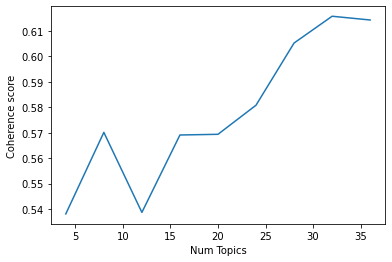

In [213]:
# Graph coherence values vs number of topics
limit=40; start=4; step=4;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [214]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.5381
Num Topics = 8  has Coherence Value of 0.5701
Num Topics = 12  has Coherence Value of 0.5387
Num Topics = 16  has Coherence Value of 0.5691
Num Topics = 20  has Coherence Value of 0.5694
Num Topics = 24  has Coherence Value of 0.5808
Num Topics = 28  has Coherence Value of 0.6052
Num Topics = 32  has Coherence Value of 0.6158
Num Topics = 36  has Coherence Value of 0.6143


In [215]:
# optimal_model = model_list[coherence_values.index(max(coherence_values))]
optimal_model = model_list[-2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(21,
  '0.222*"text" + 0.172*"nlp" + 0.115*"classification" + '
  '0.086*"natural_language" + 0.085*"processing" + 0.054*"process" + '
  '0.037*"spacy" + 0.030*"transformer" + 0.024*"bert" + 0.024*"similarity"'),
 (16,
  '0.192*"simple" + 0.101*"api" + 0.085*"search" + 0.056*"high" + '
  '0.056*"python" + 0.053*"base" + 0.047*"drive" + 0.043*"linear_regression" + '
  '0.043*"package" + 0.041*"performance"'),
 (13,
  '0.579*"learn" + 0.391*"machine" + 0.018*"bet" + 0.004*"express" + '
  '0.003*"generation" + 0.001*"strategy" + 0.001*"map" + 0.001*"big" + '
  '0.001*"recognition" + 0.000*"country"'),
 (6,
  '0.273*"app" + 0.179*"web" + 0.107*"deploy" + 0.076*"application" + '
  '0.061*"streamlit" + 0.055*"flask" + 0.040*"page" + 0.039*"heroku" + '
  '0.036*"build" + 0.031*"develop"'),
 (1,
  '0.201*"project" + 0.126*"end" + 0.066*"skill" + 0.057*"improve" + '
  '0.056*"idea" + 0.051*"build" + 0.051*"portfolio" + 0.044*"file" + '
  '0.040*"personal" + 0.034*"buy"'),
 (11,
  '0.255*"pytho

### Finding the dominant topic in each sentence

In [249]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic[['Dominant_Topic']].to_csv('dominant_topic.csv')
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,15.0,0.0483,"time, panda, technique, analyze, find, date, introduce, math, practice, post","[favorite, panda, method, chain]"
1,1,5.0,0.0459,"introduction, chart, visualization, plot, good, add, graph, type, avoid, common","[graph, think]"
2,2,1.0,0.0696,"project, end, skill, improve, idea, build, portfolio, file, personal, buy","[build, deploy, end, end, fake_new, classifier]"
3,3,13.0,0.0639,"learn, machine, bet, express, generation, strategy, map, big, recognition, country","[top, machine, learn, algorithm, know]"
4,4,20.0,0.1010,"python, tutorial, scrape, website, tweet, twitter, minute, topic_modele, web_scrape, distribution","[scrape, tutorial, airbnb, website, scrapy, scrape]"
5,5,7.0,0.1092,"top, javascript, library, sign, development, trend, framework, apple, challenge, front_end","[top, front_end, development, trend, follow]"
6,6,6.0,0.0502,"app, web, deploy, application, streamlit, flask, page, heroku, build, develop","[store, web, token, jwt]"
7,7,27.0,0.0546,"day, automate, podcast, reason, happen, datum, database, concept, important, report","[detect, non, english, language, word, remove]"
8,8,20.0,0.0483,"python, tutorial, scrape, website, tweet, twitter, minute, topic_modele, web_scrape, distribution","[master, web_scrape, completely, hero]"
9,9,24.0,0.0483,"design, problem, trick, system, tip, job, product, solve, ui, break","[weekly, awesome, trick, best_practice, kaggle]"


### Find the most representative document for each topic

In [220]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(optimal_model.num_topics)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.0830,"big, spotify, article, long, great, engineer, ...","[long, await, technology, finally, change, world]"
1,1.0,0.1152,"project, end, skill, improve, idea, build, por...","[curate, list, cool, fun, public, apis, inspir..."
2,2.0,0.1172,"free, tech, ai, network, online, programming, ...","[mit, free, online, course, learn, rise, star]"
3,3.0,0.0840,"part, world, map, black, covid, beautiful, pho...","[photograph, beautiful, place, world]"
4,4.0,0.0861,"stop, basic, user, research, power, word, give...","[focus, priceless, stop, give]"
5,5.0,0.1132,"introduction, chart, visualization, plot, good...","[keep, graph, chart, honest, avoid, common, da..."
6,6.0,0.1193,"app, web, deploy, application, streamlit, flas...","[deploy, streamlit, web, app, heroku]"
7,7.0,0.1193,"top, javascript, library, sign, development, t...","[top, demand, javascript, framework, front_end..."
8,8.0,0.0865,"work, home, part, music, rank, wrong, implemen...","[make, work, home, work]"
9,9.0,0.1153,"data, scientist, science, interview, question,...","[ask, question, data, scientist, interview, fa..."


In [223]:
# Number of Documents for Each Topic
topic_df = pd.DataFrame(df_topic_sents_keywords['Dominant_Topic'].value_counts())   
topic_df.reset_index(inplace=True)
topic_df.columns = ['Dominant_Topic', 'Num_Documents']

# Percentage of Documents for Each Topic
topic_df['Perc_Documents'] = topic_df['Num_Documents'].apply(lambda x: round(x/topic_df['Num_Documents'].values.sum(), 4))

# Merge with other df containing keywords for each topic
topic_df = topic_df.merge(sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']], 
                          left_on='Dominant_Topic', right_on='Topic_Num', how='left').drop(columns=['Topic_Num'])

topic_df

,Dominant_Topic,Num_Documents,Perc_Documents,Keywords
0,0.0,1208,0.1311,"big, spotify, article, long, great, engineer, history, company, month, facial_recognition"
1,4.0,358,0.0388,"stop, basic, user, research, power, word, give, lesson, amazon, advanced"
2,6.0,327,0.0355,"app, web, deploy, application, streamlit, flask, page, heroku, build, develop"
3,1.0,323,0.0350,"project, end, skill, improve, idea, build, portfolio, file, personal, buy"
4,12.0,323,0.0350,"life, change, brain, habit, human, method, meet, turn, smart, fall"
5,3.0,306,0.0332,"part, world, map, black, covid, beautiful, photo, risk, visual, dream"
6,13.0,297,0.0322,"learn, machine, bet, express, generation, strategy, map, big, recognition, country"
7,2.0,297,0.0322,"free, tech, ai, network, online, programming, future, language, industry, late"
8,9.0,297,0.0322,"data, scientist, science, interview, question, statistic, answer, facebook, interview_question, waste"
9,8.0,282,0.0306,"work, home, part, music, rank, wrong, implementation, move, bad, teach"


### Visualization

In [246]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7815 samples in 0.004s...
[t-SNE] Computed neighbors for 7815 samples in 0.547s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7815
[t-SNE] Computed conditional probabilities for sample 2000 / 7815
[t-SNE] Computed conditional probabilities for sample 3000 / 7815
[t-SNE] Computed conditional probabilities for sample 4000 / 7815
[t-SNE] Computed conditional probabilities for sample 5000 / 7815
[t-SNE] Computed conditional probabilities for sample 6000 / 7815
[t-SNE] Computed conditional probabilities for sample 7000 / 7815
[t-SNE] Computed conditional probabilities for sample 7815 / 7815
[t-SNE] Mean sigma: 0.000003
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.592865
[t-SNE] KL divergence after 1000 iterations: 0.503361


In [247]:
# Plot the Topic Clusters using Bokeh

output_notebook()
n_topics = lda_model.num_topics
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

Loading BokehJS ...